In [15]:
# --- config you can tweak ---
MIN_POINTS = 3              # require at least 3 readings in the last 5 days
KG_PER_MONTH = -2.0         # target pace
AVG_MONTH_DAYS = 30.44      # for kg/day conversion

import pandas as pd

# Load & clean
df = pd.read_csv("weight_log.csv")
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["weight_kg"] = pd.to_numeric(df["weight_kg"], errors="coerce")
df = df.dropna(subset=["date", "weight_kg"]).sort_values("date")

# Use date as index for time-based rolling windows
df = df.set_index("date").sort_index()

# Time-based 5-day window
roll_mean = df["weight_kg"].rolling("5D", min_periods=1).mean()
roll_count = df["weight_kg"].rolling("5D", min_periods=1).count()

# Enforce: (a) at least 5 calendar days elapsed from first reading,
#          (b) at least MIN_POINTS readings in window
first_date = df.index.min()
full_window_start = first_date + pd.Timedelta(days=4)  # first date with a full 5-day span

valid_mask = (df.index >= full_window_start) & (roll_count >= MIN_POINTS)
df["rolling_5d_time"] = roll_mean.where(valid_mask)

# First valid point where the average is allowed to appear
first_valid_label = df.index[valid_mask.argmax()] if valid_mask.any() else None

# Target line (−2 kg/month) anchored at the first valid 5-day average
target = None
if first_valid_label is not None and pd.notna(df.loc[first_valid_label, "rolling_5d_time"]):
    start_weight = df.loc[first_valid_label, "rolling_5d_time"]
    kg_per_day = KG_PER_MONTH / AVG_MONTH_DAYS
    target = (
        df.loc[first_valid_label:, []]
        .copy()
        .assign(target_weight=lambda x: start_weight + (x.index - first_valid_label).days * kg_per_day)
        .reset_index(names="date")
    )

# Back to column form for plotting
df = df.reset_index()


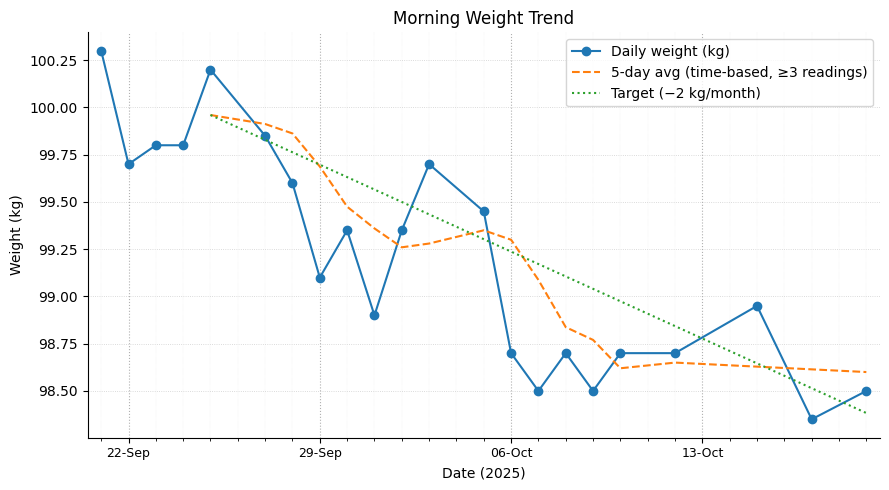

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(9, 5))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_axisbelow(True)

# Daily measurements
ax.plot(df["date"], df["weight_kg"], marker="o", label="Daily weight (kg)")

# 5-day time-based average (only where valid_mask was true)
valid_avg = df["rolling_5d_time"].notna()
if valid_avg.any():
    ax.plot(
        df.loc[valid_avg, "date"], df.loc[valid_avg, "rolling_5d_time"],
        linestyle="--", label=f"5-day avg (time-based, ≥{MIN_POINTS} readings)"
    )

# Target (−2 kg/month)
if target is not None:
    ax.plot(
        target["date"], target["target_weight"],
        linestyle=":", label="Target (−2 kg/month)"
    )

ax.set_title("Morning Weight Trend")
ax.set_ylabel("Weight (kg)")
ax.legend()

# ======= X-axis ticks/labels & grids =======

# Get first/second distinct dates (guard if there’s only one)
unique_dates = pd.to_datetime(df["date"].sort_values().unique())
start = unique_dates[0].normalize()
anchor = unique_dates[1].normalize() if len(unique_dates) >= 2 else start
end = unique_dates[-1].normalize()

# Major ticks every 7 days starting from the SECOND date
ticks = pd.date_range(start=anchor, end=end, freq="7D")
ax.set_xticks(ticks)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

# Minor ticks daily
ax.xaxis.set_minor_locator(mdates.DayLocator())

# Grids aligned to the locators
ax.grid(axis="x", which="major", linestyle=":", linewidth=0.8)
ax.grid(axis="x", which="minor", linestyle=":", linewidth=0.3, alpha=0.35)
ax.grid(axis="y", which="major", linestyle=":", linewidth=0.6, alpha=0.6)

# Keep first/last points fully visible (add a small pad around true data bounds)
x_min = pd.to_datetime(df["date"].min()).floor("D")
x_max = pd.to_datetime(df["date"].max()).ceil("D")
pad = pd.Timedelta(days=0.5)          # increase to 1 day if you want more breathing room
ax.set_xlim(x_min - pad, x_max + pad)

# Year in axis label (handles single or cross-year ranges)
year_text = str(x_min.year) if x_min.year == x_max.year else f"{x_min.year}–{x_max.year}"
ax.set_xlabel(f"Date ({year_text})")

# Neatening
ax.margins(x=0.02)                     # small margin; avoid x=0 which can clip markers
ax.tick_params(axis="x", labelsize=9)
fig.tight_layout()

# Save image
fig.savefig("weight_trend.png", dpi=150)
